<a href="https://colab.research.google.com/github/ds4ph-bme/lab3-pdijour/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Names (Enter your names below)
**Your Name and JHED:** Phoebe Dijour, pdijour1

**Partner's Name and JHED (If applicable):**  Kiana Bronder, kbronde1

# Lab 3: Prediction of Septic Shock in Patients

By **Benjamín Béjar Haro** and edited by **Kwame Kutten** and **Joseph Greenstein**

Sepsis is a life-threatening condition caused by an inflammatory immune response to an infection. It is the leading cause of death in hospitals and has a greater risk of mortality in its advanced state, also called *Septic Shock*. Early treatment of Septic Shock can dramatically increase the survival rate. Therefore, a prediction system capable of foreseeing Septic Shock would provide an early intervention window that has the potential to translate into improved patient outcomes. In this lab we look at the problem Septic Shock prediction following the approach described in [Liu et al. 2019](https://doi.org/10.1038/s41598-019-42637-5). Your goal in this lab is to reproduce some of the results in above paper. In particular you will train a a logistic regression model (referred to as GLM in the paper) to predict Septic Shock and will apply it to a test patient dataset.

In [ ]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as date
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

# Fix random number generator for reproducibility
np.random.seed(0)

## Read Data
You have been provided with the curated data used in Liu *et al.* which is a subset of the publicly available MIMIC-III database ([Johnson et al. 2016](https://doi.org/10.1038/sdata.2016.35)). The data corresponds to electronic health record data of a large population of patients, and consists of measured values over time for $28$ different features such as, heart rate, blood pressure, respiratory rate, temperature, etc. Each data point represents a particular measurement in time and for a particular patient. The data has been split into training and testing as described in Liu *et al.* and is provided to you in the form of `.csv` files. Inside those files `x` columns correspond to feature values while the `y` column represents the associated label of a particular row of feature values.  Thus $y=0$ means that the patient didn't go into Septic Shock, while a label $y=1$ indicates that the patient eventually went into Septic Shock).

In [ ]:
#===========================================
# Read data. Change path if necessary
#===========================================
try:
    # Executes if running in Google Colab
    from google.colab import drive
    drive.mount('gdrive/')
    path = "gdrive/My Drive/lab3_data/" # Change path to location of data if necessary
except:
    # Executes if running locally (e.g. Anaconda)
    path = "./"

# Read training data
traindata = pd.read_csv('/'.join((path,'glm.training.data.csv')))
Xtrain = traindata.iloc[:,1:29].values # Rows are patients, columns are clinical indicators
ytrain = traindata.iloc[:,-1].values

# Read testing data
testdata = pd.read_csv('/'.join((path,'glm.test.data.csv')))
Xtest = testdata.iloc[:,1:29].values
ytest = testdata.iloc[:,-1].values

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).


## 1. Normalize Data [5 points]
Normalize the training and test data such that each column has zero mean and unit standard deviation.  Then for both the training and test data use `np.isclose` to verify that the means and standard deviations of the normalized data are correct.

In [ ]:
"""
Write your code here
"""
# normalize variables
Xtrain -= np.mean(Xtrain, axis=0)
Xtrain /= np.std(Xtrain, axis=0)

Xtest -= np.mean(Xtest, axis=0)
Xtest /= np.std(Xtest, axis=0)

# compare SDs
print(np.isclose(np.std(Xtest), 1))
print(np.isclose(np.std(Xtrain), 1))
# compare means
print(np.isclose(np.mean(Xtest), 0))
print(np.isclose(np.mean(Xtrain), 0))

True
True
True
True


## 2. Train Generalized Linear (Logistic Regression) Model [15 points total]
 * Train a logistic regression model on the normalized data using [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). You should use the [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) from `sklearn.linear_model` with a `"log_loss"` loss, `"balanced"` class weights and a `"l1"` lasso penalty.  Specify a value for regularization parameter $\alpha \in (0,1]$ [10 points]. 
 * Plot the ROC curve and display the AUC [5 points].

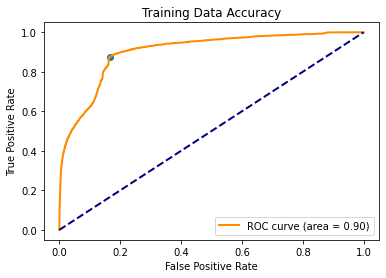

In [ ]:
"""
Write your code here
"""
# create logistic model
model = SGDClassifier(loss='log', penalty='l1', class_weight = 'balanced', alpha = 0.05)
model.fit(Xtrain, ytrain)

# calculate predicted y
ypred = model.predict_proba(Xtrain)

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(ytrain, ypred[:,1])

# Calculate AUC score
auc_score = auc(fpr, tpr)

# Calculate Operating Point
min_operating_pt = 100
for i in range(len(fpr)):
  num = (1 - tpr[i])**2 + (fpr[i])**2
  if num < min_operating_pt:
    min_operating_pt = num
    max_fpr = fpr[i]
    max_tpr = tpr[i]

# plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(max_fpr, max_tpr)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Data Accuracy')
plt.legend(loc="lower right")
plt.show()

## 3. Hyperparameter Tuning [20 points total] 
 * Refine this model by determining an optimal regularization hyperparameter $\alpha > 0$ which maximizes AUC via **5-fold cross validation** similar to Liu *et al.* You should use [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) from `sklearn.model_selection` to split your training dataset into smaller chunks that you feed to the SGDClassifier. Try several values of $\alpha \in (0,1]$. To save time you may use a small number of iterations (e.g. 5) in this step for your SGDClassifier [15 points]. 
 * Then display your optimal $\alpha$ [5 points]

In [ ]:
"""
Write your code here
"""

optimal_a_lst = []
# Loop through the KFolds
kf = KFold(n_splits = 5, shuffle = True)
for train_idx, test_idx in kf.split(Xtrain):
  X_train_f = Xtrain[train_idx, :]
  y_train_f = ytrain[train_idx]
  # Loop through different alphas
  auc_score_max = 0
  for a in np.linspace(0.01,0.1,5):
    # Initialize SGD classifier
    model = SGDClassifier(loss='log', penalty='l1', class_weight = 'balanced', alpha = a)
    # Fit and predict
    model.fit(X_train_f, y_train_f)
    ypred_kf = model.predict_proba(Xtrain[test_idx, :])

    # # Record ROC and AUC
    fpr_kf, tpr_kf, thresholds = roc_curve(ytrain[test_idx], ypred_kf[:,1])
    auc_score_kf = auc(fpr_kf, tpr_kf)
    if auc_score_kf > auc_score_max:
      print(auc_score_kf)
      auc_score_max = auc_score_kf
      optimal_a_ind = a
  optimal_a_lst.append(optimal_a_ind)

# Determine optimal alpha
optimal_a = max(set(optimal_a_lst), key=optimal_a_lst.count)
print(optimal_a)

0.9350814930697828
0.934800016471185
0.9333800086078392
0.9348519097773814
0.9337729803711879
0.01


## 4. Retrain Model [20 points total]
 * Retrain your model using your optimal regularization hyperparameter $\alpha$ from the previous step [5 points].
 * Plot the ROC curve and display it's AUC [5 points].
 * Find the **Operating Point** which gives the best TPR and FPR and add it to the plot [5 points].  
 * Display the training data accuracy at the operating point [5 points].

0.8669388402486994


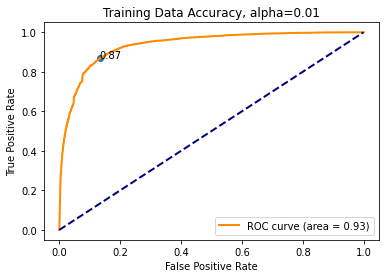

In [ ]:
"""
Write your code here
"""
# Retrain model using optimal alpha
# Plot the roc curve n display the auc
# Find the operating point

# create logistic model
model = SGDClassifier(loss='log', penalty='l1', class_weight = 'balanced', alpha = optimal_a)
model.fit(Xtrain, ytrain)

# calculate predicted y
ypred = model.predict_proba(Xtrain)

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(ytrain, ypred[:,1])

# Calculate AUC score
auc_score = auc(fpr, tpr)

# Calculate Operating Point
min_operating_pt = 100
for i in range(len(fpr)):
  num = (1 - tpr[i])**2 + (fpr[i])**2
  if num < min_operating_pt:
    min_operating_pt = num
    max_fpr = fpr[i]
    max_tpr = tpr[i]
    max_threshold = thresholds[i]

# Calculate training data accuracy
# accuracy = np.mean(ytrain == ypred[:,1].round())
accuracy = np.mean(ytrain == (ypred[:,1]>max_threshold))
print(accuracy)

# plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(max_fpr, max_tpr)
plt.annotate('%0.2f'%accuracy, (max_fpr, max_tpr))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Data Accuracy, alpha={}'.format(optimal_a))
plt.legend(loc="lower right")
plt.show()

## 5. Plot Feature Weights [10 points]
The exponentiated coefficients from our model tell us how much each feature is weighted when making a prediction.  Find the weights by exponentiating the coefficients from your model (Get coefficients from the `'coef_` attribute). Plot a bar graph of these weights with their corresponding names.  Your results should be similar to Figure 3 in Liu *et al.*

Text(0.5, 1.0, 'Feature Weights')

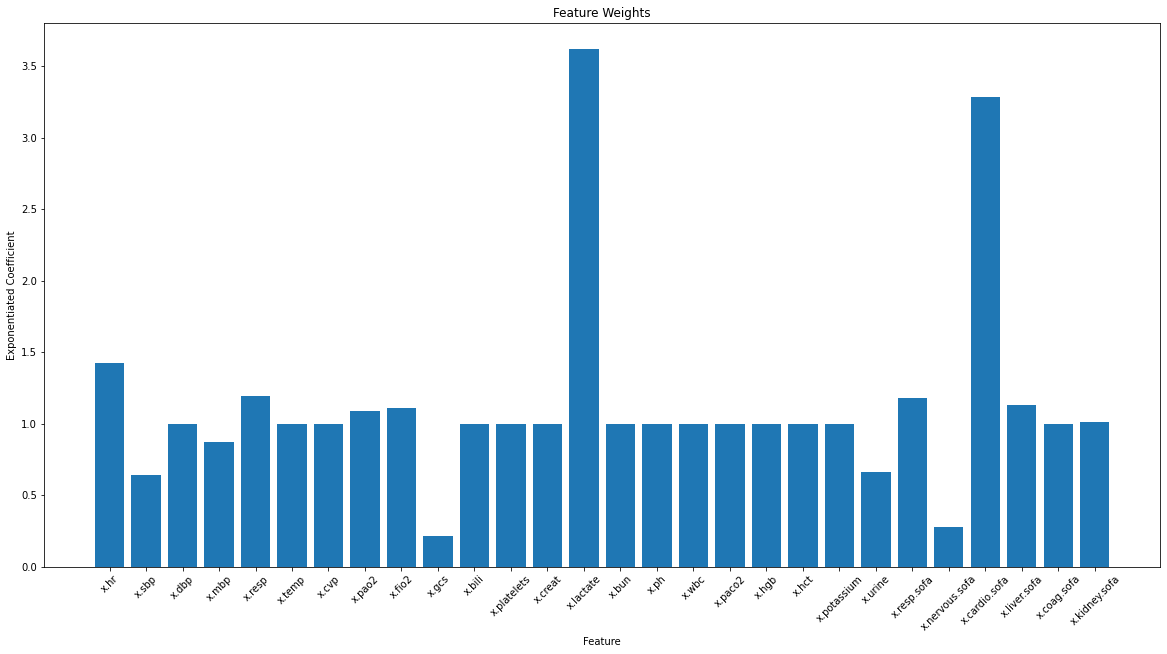

In [ ]:
featureNames = traindata.iloc[:,1:29].keys() # Names of features

"""
Write your code here
"""

coeffs = np.exp(model.coef_[0])

plt.figure(figsize=(20,10))
plt.xticks(rotation = 45)
plt.bar(featureNames, coeffs)
plt.ylabel('Exponentiated Coefficient')
plt.xlabel('Feature')
plt.title('Feature Weights')

## 6. Test Model on Patient Data [30 points total]
 * Use the patient column from the test dataset to determine the number of patients in our test dataset.  Use the test labels to create an array of this size which is $1$ if the patient went into Septic Shock *at any time* during their hospital stay and $0$ otherwise.  We can be certain that a patient went into Septic Shock if their maximum probability (risk score) attained over their hospital stay excedes some operating threshold.  Therefore you should also create a corresponding array which contains these maximum probabilities [15 points].  

 * Create an ROC curve using these arrays and display the AUC [5 points].
 * Find operating point and add it to the plot [5 points].
 * Display the accuracy for test patients at the operating point [5 points].

0.8321211221611994


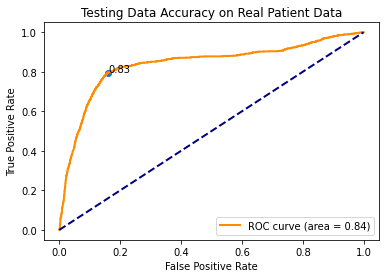

In [ ]:
patientsCol = testdata['patient'].values # Patients column from test dataset

"""
Write your code here
"""
# take all unique values from patient column
# find indices of the unique values, put into a list
# probability = predict_proba(x_test) at those indices
# ytest at those indices
# Get ROC and AUC from ytest and probability

patients_idx = []
patients = np.unique(patientsCol)
# for i in patients:
#   # patients_idx.append(np.where(patientsCol == i))
#   patients_idx.append(patientsCol.tolist().index(i))

ytest_pt = []
ypred_max = []

ypred = model.predict_proba(Xtest)[:,1]

for i in patients:
  # find time indices for each unique patient
  indices = np.where(patientsCol == i)
  # for each pt, find if they went into septic shock during hospital stay
  patient = ytest[indices]
  if patient.max() == 1:
    ytest_pt.append(1)
  else:
    ytest_pt.append(0)
  
  # for each pt, find max risk score 
  ypred_idx = ypred[indices]
  ypred_max.append(ypred_idx.max())

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(ytest_pt, ypred_max)

# Calculate AUC score
auc_score = auc(fpr, tpr)

# Calculate Operating Point
min_operating_pt = 100
for i in range(len(fpr)):
  num = (1 - tpr[i])**2 + (fpr[i])**2
  if num < min_operating_pt:
    min_operating_pt = num
    max_fpr = fpr[i]
    max_tpr = tpr[i]
    max_threshold = thresholds[i]

# Calculate testing data accuracy
# accuracy_test = np.mean(ytest_pt == np.array(ypred_max).round())
accuracy_test = np.mean(ytest_pt == (ypred_max>max_threshold))
print(accuracy_test)

# plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(max_fpr, max_tpr)
plt.annotate('%0.2f'%accuracy_test, (max_fpr, max_tpr))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Testing Data Accuracy on Real Patient Data')
plt.legend(loc="lower right")
plt.show()